In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
# Load the dataset
data = pd.read_csv('train_data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
# Check for missing values in the dataset
print(data.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [4]:
# filling the missing values in "Item_weight column" with "Mean" value
data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)

In [5]:
# filling the missing values in "Outlet_Size" column with Mode
#Here we take Outlet_Size column & Outlet_Type column since they are correlated
mode_of_Outlet_size = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [6]:
miss_values = data['Outlet_Size'].isnull()

In [7]:
data.loc[miss_values, 'Outlet_Size'] = data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [8]:
# checking for missing valua
data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [9]:
# check for similar words
data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [10]:
# replace similar words
data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [11]:
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [12]:
encoder = LabelEncoder()

In [13]:
data['Item_Identifier'] = encoder.fit_transform(data['Item_Identifier'])

data['Item_Fat_Content'] = encoder.fit_transform(data['Item_Fat_Content'])

data['Item_Type'] = encoder.fit_transform(data['Item_Type'])

data['Outlet_Identifier'] = encoder.fit_transform(data['Outlet_Identifier'])

data['Outlet_Size'] = encoder.fit_transform(data['Outlet_Size'])

data['Outlet_Location_Type'] = encoder.fit_transform(data['Outlet_Location_Type'])

data['Outlet_Type'] = encoder.fit_transform(data['Outlet_Type'])

In [14]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


<Axes: >

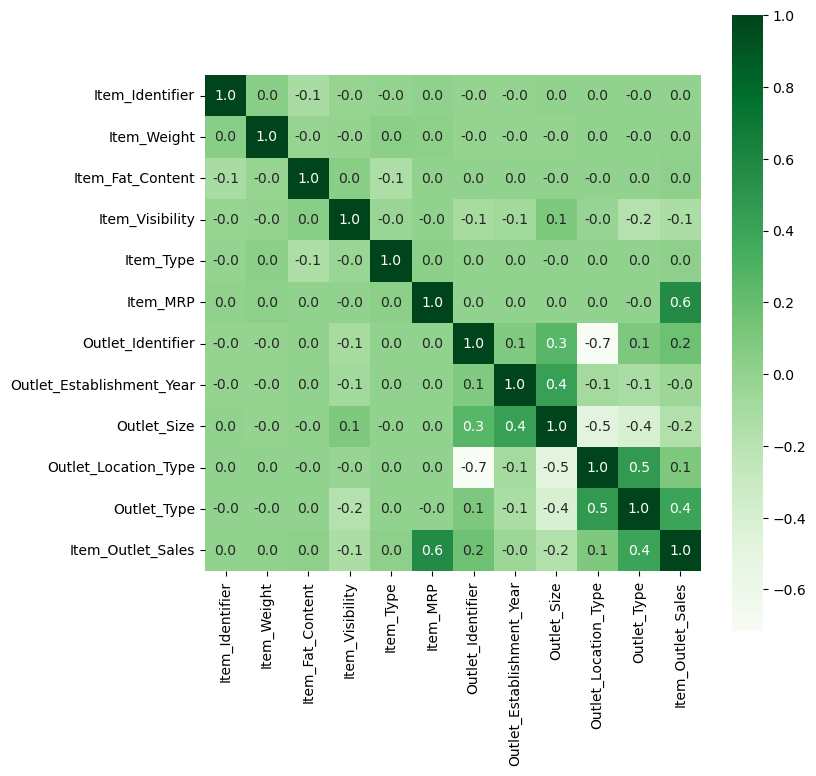

In [29]:
corr = data.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr,cbar=True,square=True,fmt='.1f',annot=True,cmap='Greens')

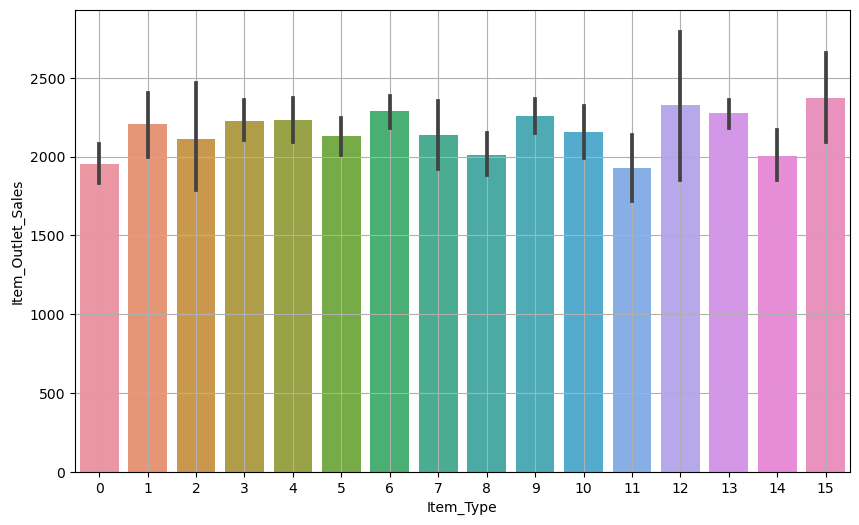

In [31]:
plt.figure(figsize=(10,6))
sns.barplot(x='Item_Type', y='Item_Outlet_Sales', data = data)
plt.grid()

<Axes: xlabel='Outlet_Establishment_Year', ylabel='count'>

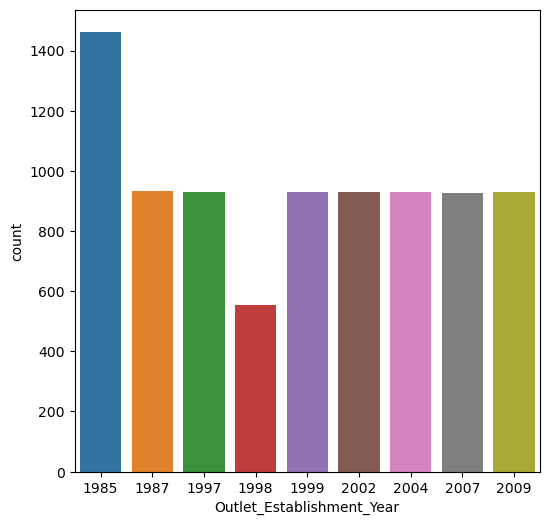

In [33]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data = data)

<Axes: xlabel='Outlet_Type', ylabel='count'>

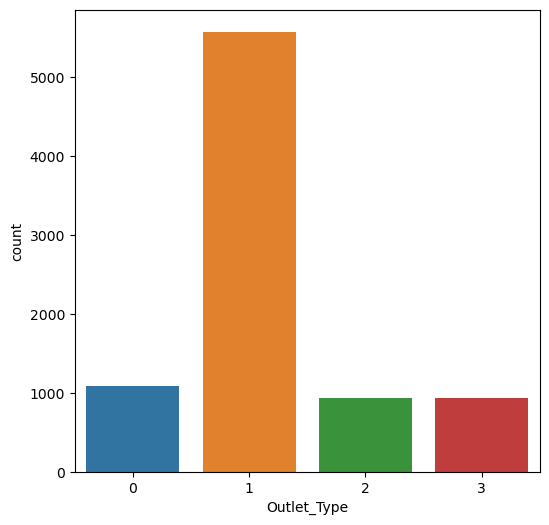

In [35]:
plt.figure(figsize=(6,6))
sns.countplot(x="Outlet_Type", data = data)

In [15]:
# Preprocess the data
X = data.drop('Item_Outlet_Sales', axis=1)  
y = data['Item_Outlet_Sales']  
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [17]:
# Define the Neural Additive Model (NAM) architecture
class NAM(nn.Module):
    def __init__(self, input_dim):
        super(NAM, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.nonlinear = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        linear_part = self.linear(x)
        nonlinear_part = self.nonlinear(x)
        output = linear_part + nonlinear_part
        return output

In [18]:
# Create an instance of the NAM model
input_dim = X_train.shape[1]
model = NAM(input_dim)

In [19]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Train the NAM model
num_epochs = 100
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [21]:
# Evaluate the NAM model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)

R-squared: 0.6111445468539286


In [22]:
print('The evalution scores XGBoost: ')
r2 = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = metrics.mean_absolute_error(y_test, y_pred)
mdae = metrics.median_absolute_error(y_test, y_pred)
print('R2: ', r2)
print('MSE :', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('MDAE: ', mdae)
print('\n')

The evalution scores XGBoost: 
R2:  0.6111445468539286
MSE : 1056897.4818917033
RMSE:  1028.0551939909176
MAE:  728.6469746496747
MDAE:  502.82359101562497




In [23]:
input_data = (156, 9.300, 0, 0.016047, 4, 249.8092, 9, 1999,1, 0, 1)
X_input = torch.tensor(input_data, dtype=torch.float32)

In [24]:
# Make the prediction
model.eval()
with torch.no_grad():
    y_pred = model(X_input).item()

In [25]:
print(y_pred)

2722118.25
